In [73]:
import os
import io 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LassoCV,Lars
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import os
import pickle
import numpy as np
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier


script_dir = os.path.abspath("../scripts")

# Append the directory to the Python path
import sys
sys.path.append(script_dir)

# Now you can import the function from the file
from data_preprocessing import data_preprocessing
from feature_eng_hyp_device_activity import generateDeviceActivityFeatures
from feature_eng_account_kmeans import get_account_related_and_kmeans_feature as generateKmeansFeatures
from feature_eng_hyp_distinct_email_same_DOB import bin_distinct_emails_same_DOB as generateEmailsDobBins
from feature_eng_hyp_name_email_similarity import bin_name_email_similarity as generateNameEmailSimilarityBins
from feature_eng_hyp_session_length import bin_session_length as generateSessionLengthBins

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

In [74]:
# Load X_train and y_train data from the processed CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Combine X_train and y_train into a single DataFrame
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [75]:
def clean_df_dtype(df):
    df = pd.DataFrame(df)
    df_label = df['fraud_bool']
    df_non_cat = df.drop(columns=['fraud_bool']).select_dtypes(exclude=['object','category'])
    df_cat =df.drop(columns=['fraud_bool']).select_dtypes(include=['object','category']) 
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(df_cat)
    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([df_non_cat, one_hot_encoded], axis=1)
    # df_encoded.info()
    X =df_encoded 
    y =df_label 
    return X,y

Model Exploration

In [76]:
X_train,y_train = clean_df_dtype(df_train)
X_test,y_test = clean_df_dtype(df_test)

In [78]:
#Baseline Model
with open('../models/baseline_model.pkl', 'rb') as file:
    baseline_model = pickle.load(file)
    
y_pred = baseline_model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
# Compute ROC AUC
bm_roc_auc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1])
fpr_bm, tpr_bm, thresholds_bm = roc_curve(y_test, baseline_model.predict_proba(X_test)[:,1])

# Print evaluation metrics
print("Model:", 'Baseline Model')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model: Baseline Model
Accuracy: 0.8443989692284372
Precision: 0.5862552594670407
Recall: 0.19209558823529413
F1 Score: 0.2893734856351679


In [60]:
def rfe_and_undostandardize(df_train, df_test, model):
    X_train, y_train = clean_df_dtype(df_train)
    X_test, y_test = clean_df_dtype(df_test)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply RFE feature selection
    rfe_selector = RFE(estimator=model)
    X_train_selected = rfe_selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = rfe_selector.transform(X_test_scaled)
    
    # Get the indices of the selected features
    selected_features_indices = rfe_selector.support_
    
    # Undo standardization on selected features
    X_train_selected_unscaled = scaler.inverse_transform(X_train_scaled)[:, selected_features_indices]
    X_test_selected_unscaled = scaler.inverse_transform(X_test_scaled)[:, selected_features_indices]
    
    # Get the column names of selected features
    selected_features = X_train.columns[selected_features_indices]
    removed_features = X_train.columns[~selected_features_indices]
 
    print("Features Removed:", removed_features)
    print("Features Kept:", selected_features)
    
    return X_train_selected_unscaled, X_test_selected_unscaled, y_train, y_test



In [28]:
# X_train, X_test, y_train, y_test = rfe_and_undostandardize(df_train, df_test, GradientBoostingClassifier())

In [80]:
# # Save X_train to CSV
# pd.DataFrame(X_train).to_csv('../data/processed/X_train_rfe.csv', index=False)
# # Save X_test to CSV
# pd.DataFrame(X_test).to_csv('../data/processed/X_test_rfe.csv', index=False)
# # Save y_train to CSV
# pd.DataFrame(y_train).to_csv('../data/processed/y_train_rfe.csv', index=False)
# # Save y_test to CSV
# pd.DataFrame(y_test).to_csv('../data/processed/y_test_rfe.csv', index=False)
X_train = pd.read_csv('../data/processed/X_train_rfe.csv')
y_train = pd.read_csv('../data/processed/y_train_rfe.csv')
X_test = pd.read_csv('../data/processed/X_test_rfe.csv')
y_test = pd.read_csv('../data/processed/y_test_rfe.csv')

In [67]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    model_directory = '../models/'
    os.makedirs(model_directory, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Define the file path for saving/loading the model
    # model_name = type(model).__name__
    model_path = os.path.join(model_directory, f"{model_name.lower()}.pkl")
    
    # Check if the model file exists
    if os.path.exists(model_path):
        # Load the model from the file
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
    else:
        # Initialize the KFold cross-validation iterator
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Perform k-fold cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        print("Cross-validation scores:", cv_scores)
        print("Mean CV accuracy:", np.mean(cv_scores))

        # Train the model on the entire training dataset
        model.fit(X_train, y_train)

        # Save the trained model
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) 
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
    # Print evaluation metrics
    print("Model:", model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    # Return the fitted model and evaluation metrics
    return model, fpr, tpr, thresholds, roc_auc

In [69]:
#DT Model 
dt_model = DecisionTreeClassifier(random_state=42)
dt_model, fpr_dt, tpr_dt, thresholds_dt, dt_roc_auc = train_and_evaluate_model('decisiontreeclassifier_model_rfe',dt_model, X_train, y_train, X_test, y_test)

#GB Model 
gb_model = GradientBoostingClassifier(random_state=42)
gb_model, fpr_gb, tpr_gb, thresholds_gb, gb_roc_auc = train_and_evaluate_model('gradientboostingclassifier_model_rfe',gb_model, X_train, y_train, X_test, y_test)

#XGB Model
xgb_model = XGBClassifier(random_state=42)
xgb_model, fpr_xgb, tpr_xgb, thresholds_xgb, xgb_roc_auc = train_and_evaluate_model('xgbclassifier_model_rfe',xgb_model, X_train, y_train, X_test, y_test)

# LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model, fpr_lgbm, tpr_lgbm, thresholds_lgbm, lgbm_roc_auc = train_and_evaluate_model('lgbmclassifier_model_rfe',lgbm_model, X_train, y_train, X_test, y_test)

# # CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model, fpr_catboost, tpr_catboost, thresholds_catboost, catboost_roc_auc = train_and_evaluate_model('catboostclassifier_model_rfe',catboost_model, X_train, y_train, X_test, y_test)

# HistGradientBoostingClassifier
hist_gb_model = HistGradientBoostingClassifier(random_state=42)
hist_gb_model, fpr_hist_gb, tpr_hist_gb, thresholds_hist_gb, hist_gb_roc_auc = train_and_evaluate_model('histgradientboostingclassifier_model_rfe',hist_gb_model, X_train, y_train, X_test, y_test)

# adaboostClassifier
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model, fpr_adaboost, tpr_adaboost, thresholds_adaboost, adaboost_roc_auc = train_and_evaluate_model('adaboostclassifier_model_rfe',adaboost_model, X_train, y_train, X_test, y_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model, fpr_rf, tpr_rf, thresholds_rf, rf_roc_auc = train_and_evaluate_model('randomforestclassifier_model_rfe',rf_model, X_train, y_train, X_test, y_test)


Model: decisiontreeclassifier_model_rfe
Accuracy: 0.8133242382901319
Precision: 0.4369784804567413
Recall: 0.4572610294117647
F1 Score: 0.4468897372557826
Model: gradientboostingclassifier_model_rfe
Accuracy: 0.8791117174473245
Precision: 0.7236335642802155
Recall: 0.4319852941176471
F1 Score: 0.5410071942446043
Model: xgbclassifier_model_rfe
Accuracy: 0.878960133393967
Precision: 0.6810506566604128
Recall: 0.5004595588235294
F1 Score: 0.576953642384106
Model: lgbmclassifier_model_rfe
Accuracy: 0.8816886463544035
Precision: 0.7073499662845584
Recall: 0.4820772058823529
F1 Score: 0.573380705110686
Model: catboostclassifier_model_rfe
Accuracy: 0.8827497347279066
Precision: 0.7073170731707317
Recall: 0.4931066176470588
F1 Score: 0.5810993772001083
Model: histgradientboostingclassifier_model_rfe
Accuracy: 0.8800212217674701
Precision: 0.6970099667774087
Recall: 0.4820772058823529
F1 Score: 0.5699538168975822
Model: adaboostclassifier_model_rfe
Accuracy: 0.8803243898741853
Precision: 0.6937

Performing Grid Search CV on RF

In [70]:
# Grid Search with Random Forest

# Define the file path for saving/loading the model
rf_grid_model_path = '../models/rf_grid_model_rfe.pkl'

# Check if the model file exists
if os.path.exists(rf_grid_model_path):
    # Load the model from the file
    with open(rf_grid_model_path, 'rb') as file:
        rf_grid_model = pickle.load(file)
else:
    # Define the parameter grid for grid search
    param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [None, 10, 20]}
    # Perform grid search with Random Forest
    rf_grid_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    rf_grid_model.fit(X_train, y_train)
    # Save the trained model
    with open(rf_grid_model_path, 'wb') as file:
        pickle.dump(rf_grid_model, file)

# Make predictions and compute ROC AUC
rf_grid_pred = rf_grid_model.predict(X_test)
rf_grid_roc_auc = roc_auc_score(y_test, rf_grid_model.predict_proba(X_test)[:,1])
fpr_rf_grid, tpr_rf_grid, thresholds_rf_grid = roc_curve(y_test, rf_grid_model.predict_proba(X_test)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, rf_grid_pred)
report = classification_report(y_test, rf_grid_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8776716689404275
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93     11018
           1       0.73      0.41      0.53      2176

    accuracy                           0.88     13194
   macro avg       0.81      0.69      0.73     13194
weighted avg       0.87      0.88      0.86     13194



Selecting Best Neural Network Model

413/413 [==============================] - 0s 700us/step


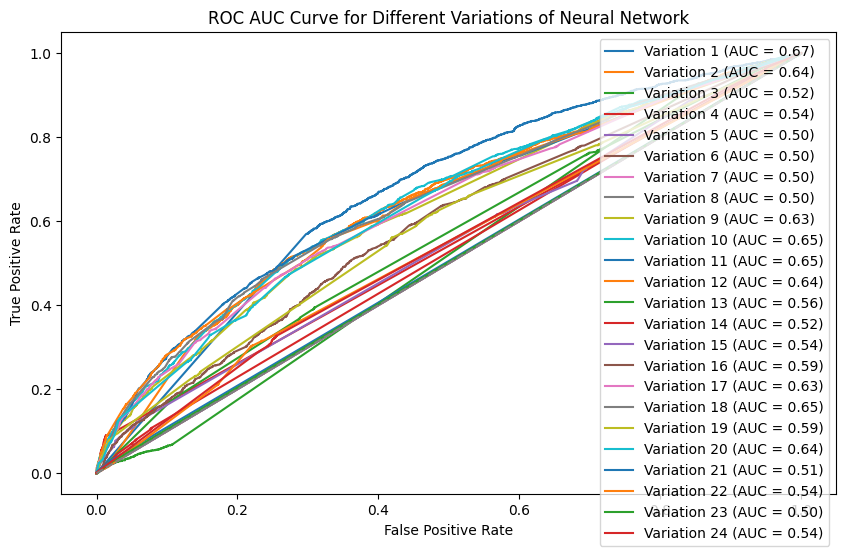

Best Model with Highest Recall:
Activation Function: relu
Optimizer: adam
Loss Function: binary_crossentropy
Number of Layers: 2
Number of Neurons: 64
ROC AUC: 0.5409027165106831
Recall: 0.010569852941176471
FPR of Best Recall Model: [0.00000000e+00 0.00000000e+00 9.07605736e-05 9.07605736e-05
 1.81521147e-04 1.81521147e-04 2.72281721e-04 2.72281721e-04
 3.63042294e-04 3.63042294e-04 4.53802868e-04 4.53802868e-04
 5.44563442e-04 5.44563442e-04 8.16845162e-04 8.16845162e-04
 1.36140860e-03 1.36140860e-03 1.54292975e-03 1.54292975e-03
 1.63369032e-03 1.63369032e-03 1.72445090e-03 1.72445090e-03
 1.81521147e-03 1.81521147e-03 1.99673262e-03 1.99673262e-03
 2.08749319e-03 2.08749319e-03 2.35977491e-03 2.35977491e-03
 2.54129606e-03 2.54129606e-03 2.63205663e-03 2.63205663e-03
 2.72281721e-03 2.72281721e-03 2.90433836e-03 2.90433836e-03
 2.99509893e-03 2.99509893e-03 3.08585950e-03 3.08585950e-03
 3.17662008e-03 3.17662008e-03 3.26738065e-03 3.26738065e-03
 3.63042294e-03 3.63042294e-03 4.0

In [46]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

# Define lists of hyperparameters to permute through
activation_functions = ['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'sgd']
loss_functions = ['binary_crossentropy']
num_layers = [1, 2]
num_neurons = [32, 64]

# Initialize lists to store ROC AUC scores, recall scores, and corresponding fpr, tpr, thresholds
roc_auc_scores = []
recall_scores = []
fprs = []
tprs = []
thresholds_list = []

# Initialize variables to track the best recall and its corresponding model index
best_recall = 0
best_model_index = -1

# Iterate over all permutations of hyperparameters
for i, activation_function in enumerate(activation_functions):
    for j, optimizer in enumerate(optimizers):
        for k, loss_function in enumerate(loss_functions):
            for num_layer in num_layers:
                for num_neuron in num_neurons:
                    # Define the architecture of the neural network
                    nn_model = Sequential()
                    nn_model.add(Dense(num_neuron, activation=activation_function, input_shape=(X_train.shape[1],)))
                    nn_model.add(Dropout(0.5))  # Add dropout layer to prevent overfitting
                    for _ in range(num_layer - 1):
                        nn_model.add(Dense(num_neuron, activation=activation_function))
                    nn_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

                    # Compile the model
                    nn_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

                    # Train the model
                    history = nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)

                    # Evaluate the model on test data
                    loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)

                    # Generate predictions for test data
                    nn_pred = nn_model.predict(X_test)
                    nn_pred_proba = nn_pred.flatten()  # Flatten the predictions to get probabilities

                    # Calculate ROC AUC score
                    nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)
                    roc_auc_scores.append(nn_roc_auc)

                    # Calculate recall score
                    nn_recall = recall_score(y_test, nn_pred.round())
                    recall_scores.append(nn_recall)

                    # Store results
                    fpr, tpr, thresholds = roc_curve(y_test, nn_pred_proba)
                    fprs.append(fpr)
                    tprs.append(tpr)
                    thresholds_list.append(thresholds)

                    # Check if current model has the best recall
                    if nn_recall > best_recall:
                        best_recall = nn_recall
                        best_model_index = len(recall_scores) - 1  # Update the index of the best model

# Plot ROC AUC for all variations
plt.figure(figsize=(10, 6))
for i, roc_auc in enumerate(roc_auc_scores):
    plt.plot(fprs[i], tprs[i], label=f'Variation {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Different Variations of Neural Network')
plt.legend()
plt.show()

# Print details of the best model with the highest recall
if best_model_index != -1:
    print("Best Model with Highest Recall:")
    print(f"Activation Function: {activation_functions[best_model_index // (len(optimizers) * len(loss_functions) * len(num_layers) * len(num_neurons))]}")
    print(f"Optimizer: {optimizers[(best_model_index // (len(loss_functions) * len(num_layers) * len(num_neurons))) % len(optimizers)]}")
    print(f"Loss Function: {loss_functions[(best_model_index // (len(num_layers) * len(num_neurons))) % len(loss_functions)]}")
    print(f"Number of Layers: {num_layers[(best_model_index // len(num_neurons)) % len(num_layers)]}")
    print(f"Number of Neurons: {num_neurons[best_model_index % len(num_neurons)]}")
    print(f"ROC AUC: {roc_auc_scores[best_model_index]}")
    print(f"Recall: {recall_scores[best_model_index]}")
else:
    print("No model found with recall greater than 0.")

# Save FPR, TPR, and thresholds of the best recall model
if best_model_index != -1:
    fpr_nn = fprs[best_model_index]
    tpr_nn = tprs[best_model_index]
    thresholds_nn = thresholds_list[best_model_index]

    print("FPR of Best Recall Model:", fpr_nn)
    print("TPR of Best Recall Model:", tpr_nn)
    print("Thresholds of Best Recall Model:", thresholds_nn)
else:
    print("No model found with recall greater than 0.")



Picking best k cluster to use

K=2: ROC AUC = 0.7129
K=3: ROC AUC = 0.7134
K=4: ROC AUC = 0.7121
K=5: ROC AUC = 0.7164
K=6: ROC AUC = 0.7235
K=7: ROC AUC = 0.7103
K=8: ROC AUC = 0.7144
K=9: ROC AUC = 0.7101
K=10: ROC AUC = 0.7122


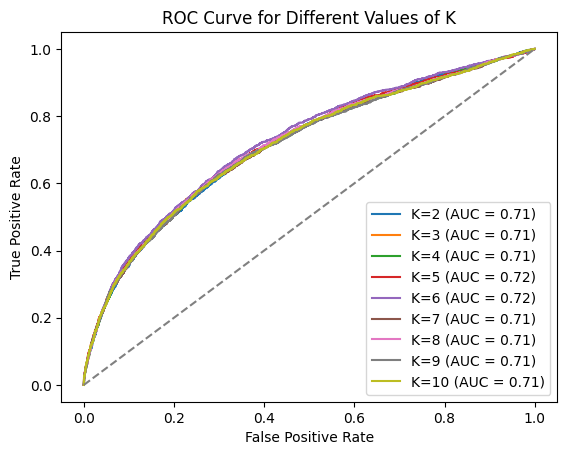

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
# Initialize lists to store fpr and tpr for each k
all_fpr = []
all_tpr = []

# Iterate through different values of k
for k in range(2, 11):
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Concatenate original features with cluster labels
    X_train_clustered = np.column_stack((X_train, cluster_labels))
    
    # Train logistic regression model
    model = LogisticRegression()
    model.fit(X_train_clustered, y_train)
    
    # Transform test data using fitted clustering model
    test_cluster_labels = kmeans.predict(X_test)
    X_test_clustered = np.column_stack((X_test, test_cluster_labels))
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test_clustered)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Append fpr and tpr to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    
    # Calculate and print ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'K={k}: ROC AUC = {roc_auc:.4f}')
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'K={k} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each k
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Values of K')
plt.legend()
plt.show()


In [81]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(X_train)

# Augment data with cluster labels
X_with_clusters_train = np.concatenate((X_train, cluster_labels.reshape(-1, 1)), axis=1)

# Split augmented data into train and test sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_with_clusters_train, y_train, test_size=0.2, random_state=42)

# Train logistic regression model on augmented data
model = LogisticRegression()
model.fit(X_train_augmented, y_train_augmented)

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test_augmented)[:, 1]

# Calculate ROC AUC score
cluster_roc_auc = roc_auc_score(y_test_augmented, y_pred_proba)
print("ROC AUC:", cluster_roc_auc)

# Plot ROC curve
fpr_cluster, tpr_cluster, thresholds_cluster = roc_curve(y_test_augmented, y_pred_proba)


ROC AUC: 0.7150418557352543


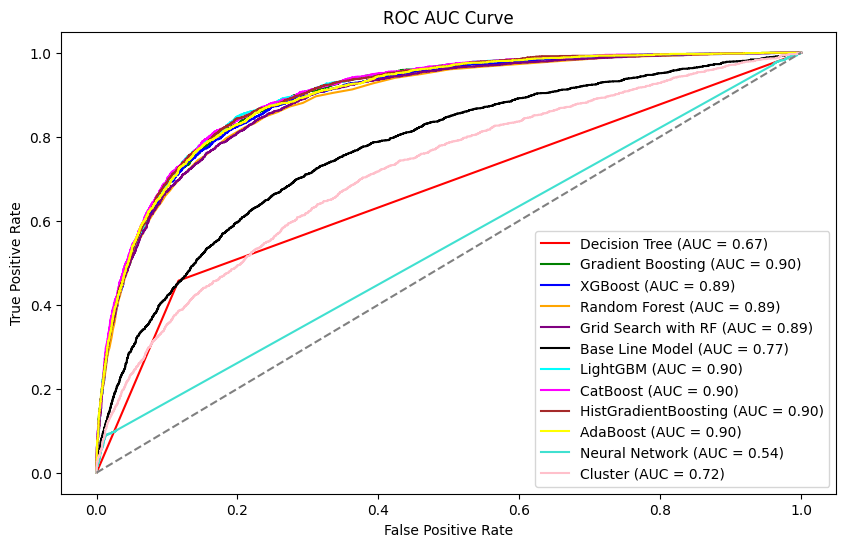

In [82]:
# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_roc_auc:.2f})', color='red')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_roc_auc:.2f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})', color='orange')
plt.plot(fpr_rf_grid, tpr_rf_grid, label=f'Grid Search with RF (AUC = {rf_grid_roc_auc:.2f})', color='purple')
plt.plot(fpr_bm, tpr_bm, label=f'Base Line Model (AUC = {bm_roc_auc:.2f})', color='black')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {lgbm_roc_auc:.2f})', color='cyan')
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {catboost_roc_auc:.2f})', color='magenta')
plt.plot(fpr_hist_gb, tpr_hist_gb, label=f'HistGradientBoosting (AUC = {hist_gb_roc_auc:.2f})', color='brown')
plt.plot(fpr_adaboost, tpr_adaboost, label=f'AdaBoost (AUC = {adaboost_roc_auc:.2f})', color='yellow')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.2f})', color='turquoise')
plt.plot(fpr_cluster, tpr_cluster, label=f'Cluster (AUC = {cluster_roc_auc:.2f})', color='pink')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


In [100]:
def get_recall(fpr,tpr,y_test):
    fpr = np.mean(fpr)
    tpr = np.mean(tpr)
    total_positive_instances = y_test[y_test == 1].count()  # Total positive instances
    total_negative_instances = len(y_test) - total_positive_instances  # Total negative instances
    # print(fpr,tpr,total_negative_instances,total_positive_instances)
    recall = (tpr * total_positive_instances) / (tpr * total_positive_instances + fpr * total_negative_instances)
    return recall

In [105]:
fpr_tpr_list = [
    (fpr_dt, tpr_dt),
    (fpr_gb, tpr_gb),
    (fpr_xgb, tpr_xgb),
    (fpr_rf, tpr_rf),
    (fpr_rf_grid, tpr_rf_grid),
    (fpr_bm, tpr_bm),
    (fpr_lgbm, tpr_lgbm),
    (fpr_catboost, tpr_catboost),
    (fpr_hist_gb, tpr_hist_gb),
    (fpr_adaboost, tpr_adaboost),
    (fpr_nn, tpr_nn),
    (fpr_cluster, tpr_cluster)
]

model_names = [
    'Decision Tree',
    'Gradient Boosting',
    'XGBoost',
    'Random Forest',
    'Grid Search with RF',
    'Base Line Model',
    'LightGBM',
    'CatBoost',
    'HistGradientBoosting',
    'AdaBoost',
    'Neural Network',
    'Cluster'
]

# Iterate over each model's FPR and TPR values
i=0
for fpr, tpr in fpr_tpr_list:
    model_name = model_names[i]
    i+=1
    # Calculate recall for the current model
    recall = get_recall(fpr, tpr, y_test)
    print(f"Recall for the {model_name} model: {recall.item():.2f}")

# Print the model with the highest recall
best_model_index = np.argmax([get_recall(fpr, tpr, y_test) for fpr, tpr in fpr_tpr_list])
best_model_name = model_names[best_model_index]
best_model_recall = get_recall(*fpr_tpr_list[best_model_index], y_test)
print(f"\nThe model with the highest recall is: {best_model_name} (Recall: {best_model_recall.item():.2f})")


Recall for the Decision Tree model: 0.20
Recall for the Gradient Boosting model: 0.44
Recall for the XGBoost model: 0.43
Recall for the Random Forest model: 0.41
Recall for the Grid Search with RF model: 0.42
Recall for the Base Line Model model: 0.28
Recall for the LightGBM model: 0.45
Recall for the CatBoost model: 0.45
Recall for the HistGradientBoosting model: 0.44
Recall for the AdaBoost model: 0.41
Recall for the Neural Network model: 0.18
Recall for the Cluster model: 0.25

The model with the highest recall is: LightGBM (Recall: 0.45)


Since it has been established that GB and RF are the best models, we shall observe which features work best with Gradient Boosting.

In [8]:
import os
import pickle
import numpy as np
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lars
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans

# Load X_train and y_train data from the processed CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Combine X_train and y_train into a single DataFrame
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [9]:
feature_engineering_methods = [
    generateDeviceActivityFeatures,
    generateKmeansFeatures,
    generateEmailsDobBins,
    generateNameEmailSimilarityBins,
    generateSessionLengthBins
]

In [10]:
def standardize_and_select_features(df_train, df_test):
    X_train, y_train = clean_df_dtype(df_train)
    X_test, y_test = clean_df_dtype(df_test)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply LARS feature selection
    lars_model = Lars()
    lars_model.fit(X_train_scaled, y_train)
    selected_features = lars_model.coef_ != 0
    
    # Select relevant features
    X_train_selected = X_train_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]
    
    # Print features removed and features kept
    removed_features = X_train.columns[~selected_features]
    kept_features = X_train.columns[selected_features]
    print("Features Removed:", removed_features)
    print("Features Kept:", kept_features)
    
    # Print the shapes of selected features
    print("Shape of X_train_selected:", X_train_selected.shape)
    print("Shape of X_test_selected:", X_test_selected.shape)
    
    return X_train_selected, X_test_selected, y_train, y_test, removed_features,kept_features


In [11]:
# Function to generate combinations of feature engineering methods
def generate_combinations():
    combinations_list = []
    for r in range(1, len(feature_engineering_methods) + 1):
        combinations_list.extend(combinations(feature_engineering_methods, r))
    return combinations_list

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pickle

def train_model_with_feature_engineering(model_name, model, df_train, df_test, combinations_list):
    models = []
    for i, perm in enumerate(combinations_list, start=1):
        model_path = f"../models/{model_name}_{i}_model.pkl"
        
        df_train_copy = df_train.copy()
        df_test_copy = df_test.copy()
        
        # Apply feature engineering functions
        for func in perm:
            func(df_train_copy)
            func(df_test_copy)
        
        # Standardize and select features
        X_train, X_test, y_train, y_test, removed_features, kept_features = standardize_and_select_features(df_train_copy, df_test_copy)
        
        # Print removed and kept features
        print(f"Removed Features ({model_name}_{i}):", removed_features)
        print(f"Kept Features ({model_name}_{i}):", kept_features)
        
        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        print("Cross-validation scores:", cv_scores)
        print("Mean CV accuracy:", np.mean(cv_scores))
        
        # Train the model on the entire training dataset
        model.fit(X_train, y_train)
        
        # Save the trained model
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred) 
        
        # Compute ROC AUC
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        
        # Print evaluation metrics
        print("Model:", model_name)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        
        # Save the model and its details
        models.append((model, perm, model_name, accuracy, precision, recall, f1, fpr, tpr, roc_auc))
    
    return models

In [13]:

def visualize_roc_auc(models):
    plt.figure(figsize=(10, 6))
    i=0
    for model, perm, model_name, accuracy, precision, recall, f1, fpr, tpr, roc_auc in models:
        i+=1
        plt.plot(fpr, tpr, label=f'Model {i}(AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()



In [14]:
def create_model_details_table(models):
    model_details = []
    for i, (fe_model, perm, model_name, accuracy, precision, recall, f1, _, _, _) in enumerate(models, start=1):
        features_engineered = ', '.join([func.__name__ for func in perm])
        model_details.append({
            'Model Number': i,
            'Model Name': model_name,
            'Features Engineered': features_engineered,
            'Recall': recall,
            'Precision': precision,
            'Accuracy': accuracy,
            'F1 Score': f1
            
        })
    model_details_df = pd.DataFrame(model_details)
    return model_details_df


In [92]:
combinations_list = generate_combinations()
xgb = XGBClassifier(random_state=42)
xgb_models = train_model_with_feature_engineering('xgb', xgb, df_train, df_test, combinations_list)

Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Features Removed: Index(['payment_type_AB', 'employment_status_CD', 'housing_status_BC',
       'source_INTERNET', 'device_os_other'],
      dtype='object')
Features Kept: Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distin

In [55]:
combinations_list

[(<function feature_eng_hyp_device_activity.generateDeviceActivityFeatures(data)>,),
 (<function feature_eng_account_kmeans.get_account_related_and_kmeans_feature(df)>,),
 (<function feature_eng_hyp_distinct_email_same_DOB.bin_distinct_emails_same_DOB(df)>,),
 (<function feature_eng_hyp_name_email_similarity.bin_name_email_similarity(df)>,),
 (<function feature_eng_hyp_session_length.bin_session_length(df)>,),
 (<function feature_eng_hyp_device_activity.generateDeviceActivityFeatures(data)>,
  <function feature_eng_account_kmeans.get_account_related_and_kmeans_feature(df)>),
 (<function feature_eng_hyp_device_activity.generateDeviceActivityFeatures(data)>,
  <function feature_eng_hyp_distinct_email_same_DOB.bin_distinct_emails_same_DOB(df)>),
 (<function feature_eng_hyp_device_activity.generateDeviceActivityFeatures(data)>,
  <function feature_eng_hyp_name_email_similarity.bin_name_email_similarity(df)>),
 (<function feature_eng_hyp_device_activity.generateDeviceActivityFeatures(data)>

In [96]:
with open('../data/xgb_models.pkl', 'wb') as f:
    pickle.dump(xgb_models, f)

with open('./data/rf_models.pkl', 'wb') as f:
    pickle.dump(rf_models, f)

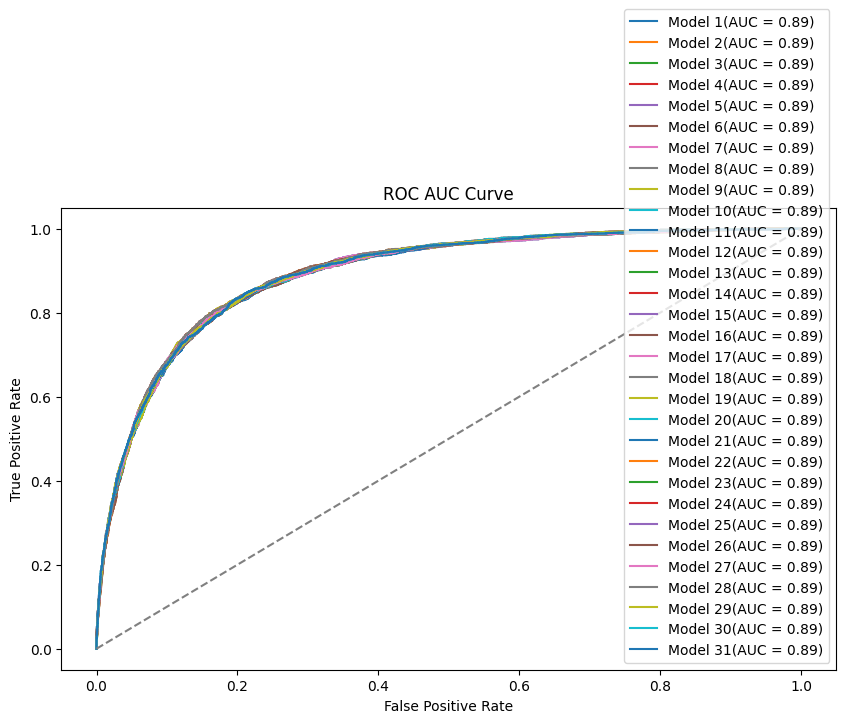

    Model Number Model Name  \
0              1        xgb   
1              2        xgb   
2              3        xgb   
3              4        xgb   
4              5        xgb   
5              6        xgb   
6              7        xgb   
7              8        xgb   
8              9        xgb   
9             10        xgb   
10            11        xgb   
11            12        xgb   
12            13        xgb   
13            14        xgb   
14            15        xgb   
15            16        xgb   
16            17        xgb   
17            18        xgb   
18            19        xgb   
19            20        xgb   
20            21        xgb   
21            22        xgb   
22            23        xgb   
23            24        xgb   
24            25        xgb   
25            26        xgb   
26            27        xgb   
27            28        xgb   
28            29        xgb   
29            30        xgb   
30            31        xgb   

       

In [93]:
visualize_roc_auc(xgb_models)
xgb_model_details_df = create_model_details_table(xgb_models)
print(xgb_model_details_df)

In [94]:
rf = RandomForestClassifier(random_state=42)
rf_models = train_model_with_feature_engineering('rf', rf, df_train, df_test, combinations_list) 

Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Features Removed: Index(['payment_type_AB', 'employment_status_CD', 'housing_status_BC',
       'source_INTERNET', 'device_os_other'],
      dtype='object')
Features Kept: Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distin

In [17]:
with open('../models/rf_models.pkl', 'rb') as file:
            rf_models = pickle.load(file)

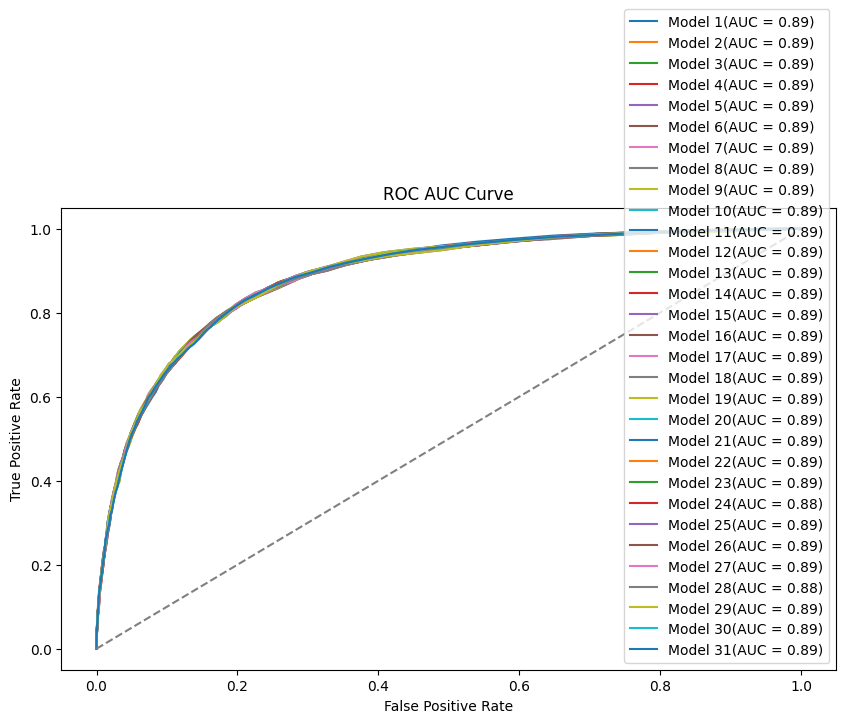

    Model Number Model Name  \
0              1         rf   
1              2         rf   
2              3         rf   
3              4         rf   
4              5         rf   
5              6         rf   
6              7         rf   
7              8         rf   
8              9         rf   
9             10         rf   
10            11         rf   
11            12         rf   
12            13         rf   
13            14         rf   
14            15         rf   
15            16         rf   
16            17         rf   
17            18         rf   
18            19         rf   
19            20         rf   
20            21         rf   
21            22         rf   
22            23         rf   
23            24         rf   
24            25         rf   
25            26         rf   
26            27         rf   
27            28         rf   
28            29         rf   
29            30         rf   
30            31         rf   

       

In [18]:
visualize_roc_auc(rf_models)
rf_model_details_df = create_model_details_table(rf_models)
print(rf_model_details_df)

The best model we have from here is the xgb model on feature_eng_hyp_distinct_email_same_DOB fe dataset. 
Next, we evaluate the performance of the other gb models after performing rfe on dataset with all the functions. 

In [64]:
df_train_fe = pd.concat([X_train, y_train], axis=1)
df_test_fe = pd.concat([X_test, y_test], axis=1)

for feature in feature_engineering_methods:
    feature(df_train_fe)
    feature(df_test_fe)

X_train_rfe_fe, X_test_rfe_fe , y_train_rfe_fe , y_test_rfe_fe = rfe_and_undostandardize(df_train_fe, df_test_fe, GradientBoostingClassifier())

Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.
Features Removed: Index(['velocity_6h', 'phone_mobile_valid', 'have_initial_bal',
       'payment_type_AA', 'payment_type_AB', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BF',
       'housing_status_BG', 'source_INTERNET', 'source_TELEAPP',
       'device_os_other', 'device_os_x11', 'emails_bin_0-10',
       'emails_bin_10-20', 'emails_bin_20-30', 'emails_bin_>30',
       'name_email_similarity_bins_0-0.2',
       'name_email_similarity_bins_0.2-0.4',
       'name_email_similarity_bins_0.4-0.6',
       'name_email_similarity_bins_0.6-0.8',
       'na

In [106]:
# # Save X_train to CSV
# pd.DataFrame(X_train_rfe_fe).to_csv('../data/processed/X_train_rfe_fe.csv', index=False)
# # Save X_test to CSV
# pd.DataFrame(X_test_rfe_fe).to_csv('../data/processed/X_test_rfe_fe.csv', index=False)
# # Save y_train to CSV
# pd.DataFrame(y_train_rfe_fe).to_csv('../data/processed/y_train_rfe_fe.csv', index=False)
# # Save y_test to CSV
# pd.DataFrame(y_test_rfe_fe).to_csv('../data/processed/y_test_rfe_fe.csv', index=False)
X_train_rfe_fe = pd.read_csv('../data/processed/X_train_rfe_fe.csv')
y_train_rfe_fe = pd.read_csv('../data/processed/y_train_rfe_fe.csv')
X_test_rfe_fe = pd.read_csv('../data/processed/X_test_rfe_fe.csv')
y_test_rfe_fe = pd.read_csv('../data/processed/y_test_rfe_fe.csv')

In [107]:
#DT Model 
dt_model = DecisionTreeClassifier(random_state=42)
dt_model, fpr_dt, tpr_dt, thresholds_dt, dt_roc_auc = train_and_evaluate_model('decisiontreeclassifier_model',dt_model, X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

#GB Model 
gb_model = GradientBoostingClassifier(random_state=42)
gb_model, fpr_gb, tpr_gb, thresholds_gb, gb_roc_auc = train_and_evaluate_model('gradientboostingclassifier_model',gb_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

#XGB Model
xgb_model = XGBClassifier(random_state=42)
xgb_model, fpr_xgb, tpr_xgb, thresholds_xgb, xgb_roc_auc = train_and_evaluate_model('xgbclassifier_model',xgb_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

# LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model, fpr_lgbm, tpr_lgbm, thresholds_lgbm, lgbm_roc_auc = train_and_evaluate_model('lgbmclassifier_model',lgbm_model, X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

# # CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model, fpr_catboost, tpr_catboost, thresholds_catboost, catboost_roc_auc = train_and_evaluate_model('catboostclassifier_model',catboost_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

# HistGradientBoostingClassifier
hist_gb_model = HistGradientBoostingClassifier(random_state=42)
hist_gb_model, fpr_hist_gb, tpr_hist_gb, thresholds_hist_gb, hist_gb_roc_auc = train_and_evaluate_model('histgradientboostingclassifier_model',hist_gb_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

# adaboostClassifier
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model, fpr_adaboost, tpr_adaboost, thresholds_adaboost, adaboost_roc_auc = train_and_evaluate_model('adaboostclassifier_model', adaboost_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model, fpr_rf, tpr_rf, thresholds_rf, rf_roc_auc = train_and_evaluate_model('randomforestclassifier_model', rf_model,  X_train_rfe_fe, y_train_rfe_fe , X_test_rfe_fe, y_test_rfe_fe)

Model: decisiontreeclassifier_model
Accuracy: 0.8105199333030165
Precision: 0.4294425087108014
Recall: 0.453125
F1 Score: 0.4409660107334526
Model: gradientboostingclassifier_model
Accuracy: 0.8797180536607548
Precision: 0.726016884113584
Recall: 0.43474264705882354
F1 Score: 0.5438344351825237
Model: xgbclassifier_model
Accuracy: 0.8784295892072154
Precision: 0.6807838179519595
Recall: 0.49494485294117646
F1 Score: 0.5731772219265566
Model: lgbmclassifier_model
Accuracy: 0.8806275579809004
Precision: 0.7004669779853235
Recall: 0.48253676470588236
F1 Score: 0.5714285714285714
Model: catboostclassifier_model
Accuracy: 0.8825223586478702
Precision: 0.7051114023591087
Recall: 0.4944852941176471
F1 Score: 0.5813074014046461
Model: histgradientboostingclassifier_model
Accuracy: 0.8808549340609367
Precision: 0.7010652463382158
Recall: 0.48391544117647056
F1 Score: 0.5725938009787929
Model: adaboostclassifier_model
Accuracy: 0.881158102167652
Precision: 0.6946222791293214
Recall: 0.4986213235

In [108]:
# Grid Search with Random Forest

# Define the file path for saving/loading the model
rf_grid_model_path = '../models/rf_grid_model.pkl'

# Check if the model file exists
if os.path.exists(rf_grid_model_path):
    # Load the model from the file
    with open(rf_grid_model_path, 'rb') as file:
        rf_grid_model = pickle.load(file)
else:
    # Define the parameter grid for grid search
    param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [None, 10, 20]}
    # Perform grid search with Random Forest
    rf_grid_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    rf_grid_model.fit(X_train, y_train)
    # Save the trained model
    with open(rf_grid_model_path, 'wb') as file:
        pickle.dump(rf_grid_model, file)

# Make predictions and compute ROC AUC
rf_grid_pred = rf_grid_model.predict(X_test)
rf_grid_roc_auc = roc_auc_score(y_test, rf_grid_model.predict_proba(X_test)[:,1])
fpr_rf_grid, tpr_rf_grid, thresholds_rf_grid = roc_curve(y_test, rf_grid_model.predict_proba(X_test)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, rf_grid_pred)
report = classification_report(y_test, rf_grid_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8776716689404275
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93     11018
           1       0.73      0.41      0.53      2176

    accuracy                           0.88     13194
   macro avg       0.81      0.69      0.73     13194
weighted avg       0.87      0.88      0.86     13194



In [109]:
from sklearn.ensemble import VotingClassifier

# Define the base models
models = [
    ('dt', dt_model),
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('hist_gb', hist_gb_model),
    ('adaboost', adaboost_model),
    ('rf', rf_model),
    ('rf_grid', rf_grid_model)
]

# Hard Voting Ensemble
if os.path.exists('../models/hard_voting_model.pkl'):
    with open('../models/hard_voting_model.pkl', 'rb') as file:
        hard_voting_model = pickle.load(file)
else:
    hard_voting_model = VotingClassifier(estimators=models, voting='hard')
    hard_voting_model.fit(X_train_rfe_fe, y_train_rfe_fe)
    with open('../models/hard_voting_model.pkl', 'wb') as file:
        pickle.dump(hard_voting_model, file)

# Soft Voting Ensemble
if os.path.exists('../models/soft_voting_model.pkl'):
    with open('../models/soft_voting_model.pkl', 'rb') as file:
        soft_voting_model = pickle.load(file)
else:
    soft_voting_model = VotingClassifier(estimators=models, voting='soft')
    soft_voting_model.fit(X_train_rfe_fe, y_train_rfe_fe)

    with open('../models/soft_voting_model.pkl', 'wb') as file:
            pickle.dump(soft_voting_model, file) 

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score

# Define the base models
models = [
    ('dt', dt_model),
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('hist_gb', hist_gb_model),
    ('adaboost', adaboost_model),
    ('rf', rf_model),
    ('rf_grid', rf_grid_model)
]

# Function to evaluate recall for a given ensemble
def evaluate_recall(ensemble, X, y):
    if ensemble.voting == 'hard':
        y_pred = ensemble.predict(X)
    else:  # For soft voting, use predict_proba to get probabilities
        y_pred_proba = ensemble.predict_proba(X)
        y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)  # Convert probabilities to binary predictions
    return recall_score(y, y_pred)

# Find models for hard voting
best_hard_models = []
best_hard_recall = 0
for model_name, model in models:
    ensemble = VotingClassifier(estimators=[(model_name, model)], voting='hard')
    ensemble.fit(X_train_rfe_fe, y_train_rfe_fe)
    recall = evaluate_recall(ensemble, X_val, y_val)
    if recall > best_hard_recall:
        best_hard_recall = recall
        best_hard_models = [(model_name, model)]
    elif recall == best_hard_recall:
        best_hard_models.append((model_name, model))

# Find models for soft voting
best_soft_models = []
best_soft_recall = 0
for model_name, model in models:
    ensemble = VotingClassifier(estimators=[(model_name, model)], voting='soft')
    ensemble.fit(X_train_rfe_fe, y_train_rfe_fe)
    recall = evaluate_recall(ensemble, X_val, y_val)
    if recall > best_soft_recall:
        best_soft_recall = recall
        best_soft_models = [(model_name, model)]
    elif recall == best_soft_recall:
        best_soft_models.append((model_name, model))

# Train the final hard voting ensemble
hard_voting_model = VotingClassifier(estimators=best_hard_models, voting='hard')
hard_voting_model.fit(X_train_rfe_fe, y_train_rfe_fe)

# Train the final soft voting ensemble
soft_voting_model = VotingClassifier(estimators=best_soft_models, voting='soft')
soft_voting_model.fit(X_train_rfe_fe, y_train_rfe_fe)


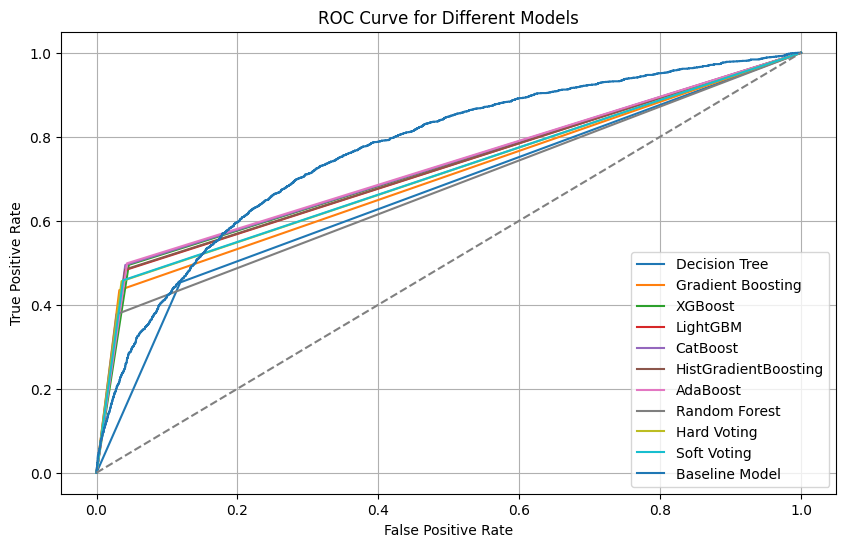

Model: Decision Tree
Recall: 0.453125
Accuracy: 0.8105199333030165
F1 Score: 0.4409660107334526
Precision: 0.4294425087108014

Model: Gradient Boosting
Recall: 0.43474264705882354
Accuracy: 0.8797180536607548
F1 Score: 0.5438344351825237
Precision: 0.726016884113584

Model: XGBoost
Recall: 0.49494485294117646
Accuracy: 0.8784295892072154
F1 Score: 0.5731772219265566
Precision: 0.6807838179519595

Model: LightGBM
Recall: 0.48253676470588236
Accuracy: 0.8806275579809004
F1 Score: 0.5714285714285714
Precision: 0.7004669779853235

Model: CatBoost
Recall: 0.4944852941176471
Accuracy: 0.8825223586478702
F1 Score: 0.5813074014046461
Precision: 0.7051114023591087

Model: HistGradientBoosting
Recall: 0.48391544117647056
Accuracy: 0.8808549340609367
F1 Score: 0.5725938009787929
Precision: 0.7010652463382158

Model: AdaBoost
Recall: 0.49862132352941174
Accuracy: 0.881158102167652
F1 Score: 0.5805243445692884
Precision: 0.6946222791293214

Model: Random Forest
Recall: 0.3772977941176471
Accuracy: 

In [111]:
# Initialize lists to store model names and ROC curves
model_names = []
roc_curves = []

# Lists to store evaluation metrics
recalls = []
accuracies = []
f1_scores = []
precisions = []

# List of all models
all_models = [
    ('Decision Tree', dt_model),
    ('Gradient Boosting', gb_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgbm_model),
    ('CatBoost', catboost_model),
    ('HistGradientBoosting', hist_gb_model),
    ('AdaBoost', adaboost_model),
    ('Random Forest', rf_model),
    # ('Grid Search Random Forest', rf_grid_model)
    ('Hard Voting', hard_voting_model), 
    ('Soft Voting', soft_voting_model)
]

# Iterate over each model
for model_name, model in all_models:
    # Make predictions
    if model_name in ['Hard Voting', 'Soft Voting']:
        y_pred = model.predict(X_test_rfe_fe)
    else:
        y_pred = model.predict(X_test_rfe_fe)
    
    # Calculate evaluation metrics
    recall = recall_score(y_test_rfe_fe, y_pred)
    accuracy = accuracy_score(y_test_rfe_fe, y_pred)
    f1 = f1_score(y_test_rfe_fe, y_pred)
    precision = precision_score(y_test_rfe_fe, y_pred)
    
    # Append model name and evaluation metrics to lists
    model_names.append(model_name)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_rfe_fe, y_pred)
    roc_curves.append((fpr, tpr))

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr) in zip(model_names, roc_curves):
    plt.plot(fpr, tpr, label=model_name)
plt.plot(fpr_bm,tpr_bm,label = 'Baseline Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print evaluation metrics for each model
for i, model_name in enumerate(model_names):
    print(f"Model: {model_name}")
    print(f"Recall: {recalls[i]}")
    print(f"Accuracy: {accuracies[i]}")
    print(f"F1 Score: {f1_scores[i]}")
    print(f"Precision: {precisions[i]}")
    print()


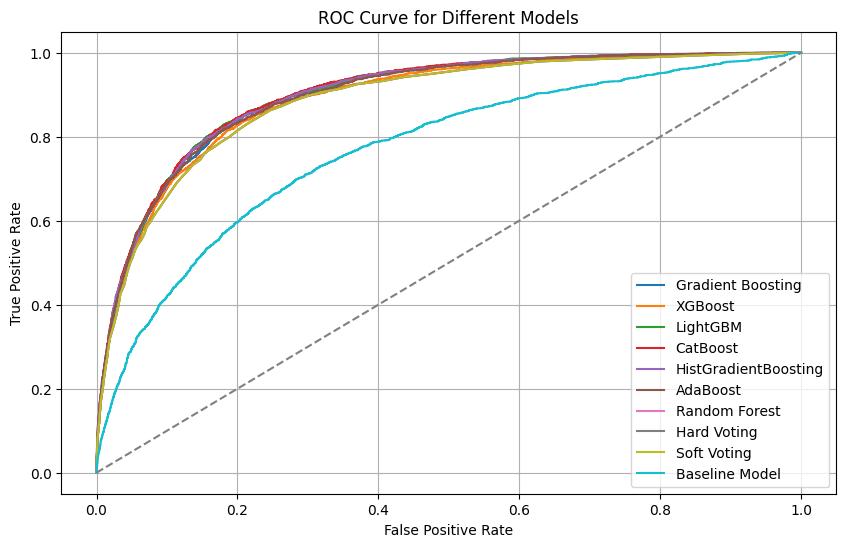

Model: Gradient Boosting
Recall: 0.43474264705882354
Accuracy: 0.8797180536607548
F1 Score: 0.5438344351825237
Precision: 0.726016884113584

Model: XGBoost
Recall: 0.49494485294117646
Accuracy: 0.8784295892072154
F1 Score: 0.5731772219265566
Precision: 0.6807838179519595

Model: LightGBM
Recall: 0.48253676470588236
Accuracy: 0.8806275579809004
F1 Score: 0.5714285714285714
Precision: 0.7004669779853235

Model: CatBoost
Recall: 0.4944852941176471
Accuracy: 0.8825223586478702
F1 Score: 0.5813074014046461
Precision: 0.7051114023591087

Model: HistGradientBoosting
Recall: 0.48391544117647056
Accuracy: 0.8808549340609367
F1 Score: 0.5725938009787929
Precision: 0.7010652463382158

Model: AdaBoost
Recall: 0.49862132352941174
Accuracy: 0.881158102167652
F1 Score: 0.5805243445692884
Precision: 0.6946222791293214

Model: Random Forest
Recall: 0.3975183823529412
Accuracy: 0.8746399878732757
F1 Score: 0.5112293144208038
Precision: 0.7160596026490066

Model: Hard Voting
Recall: 0.45588235294117646
A

In [115]:
# Initialize lists to store model names and ROC curves
model_names = []
roc_curves = []

# Lists to store evaluation metrics
recalls = []
accuracies = []
f1_scores = []
precisions = []

# List of all models
all_models = [
    # ('Decision Tree', dt_model),
    ('Gradient Boosting', gb_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgbm_model),
    ('CatBoost', catboost_model),
    ('HistGradientBoosting', hist_gb_model),
    ('AdaBoost', adaboost_model),
    ('Random Forest', rf_model),
    ('Hard Voting', hard_voting_model), 
    ('Soft Voting', soft_voting_model)
]

# Iterate over each model
for model_name, model in all_models:
    # Make predictions
    if model_name in ['Hard Voting', 'Soft Voting']:
        # For voting models, use predict
        y_pred = model.predict(X_test_rfe_fe)
    else:
        # For individual models, handle probability estimates
        try:
            y_pred_proba = model.predict_proba(X_test_rfe_fe)[:, 1]
        except AttributeError:
            # Some models may not support predict_proba, in that case, use decision_function
            y_pred_proba = model.decision_function(X_test_rfe_fe)
    
        # Convert probabilities to binary predictions using a threshold
        threshold = 0.5  # Example threshold, you can adjust this
        y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate evaluation metrics
    recall = recall_score(y_test_rfe_fe, y_pred)
    accuracy = accuracy_score(y_test_rfe_fe, y_pred)
    f1 = f1_score(y_test_rfe_fe, y_pred)
    precision = precision_score(y_test_rfe_fe, y_pred)
    
    # Append model name and evaluation metrics to lists
    model_names.append(model_name)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_rfe_fe, y_pred_proba)
    roc_curves.append((fpr, tpr))

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr) in zip(model_names, roc_curves):
    plt.plot(fpr, tpr, label=model_name)
plt.plot(fpr_bm, tpr_bm, label='Baseline Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print evaluation metrics for each model
for i, model_name in enumerate(model_names):
    print(f"Model: {model_name}")
    print(f"Recall: {recalls[i]}")
    print(f"Accuracy: {accuracies[i]}")
    print(f"F1 Score: {f1_scores[i]}")
    print(f"Precision: {precisions[i]}")
    print()
